In [48]:
%matplotlib inline

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('default')

def getPieDataByPercentile(df, percentile):
    
    percentile = df.quantile(percentile)['counts']

    df_upper = df.loc[df.counts >= percentile]
    df_lower = df.loc[df.counts < percentile]

    df_other = pd.DataFrame(columns=['hostCo','counts'])
    df_other.loc[0] = ['other', df_lower['counts'].sum()]

    df_pie = [df_upper,df_other]

    result = pd.concat(df_pie)

    # Pie chart
    labels = result['hostCo'].values
    sizes = result['counts'].values
    
    return labels, sizes

def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    boxprops = dict(linewidth=2)
    return df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(20,10), boxprops=boxprops)

df = pd.read_csv("data/data.csv")

### Boxplot of RTT by origin country (where content is accessed)

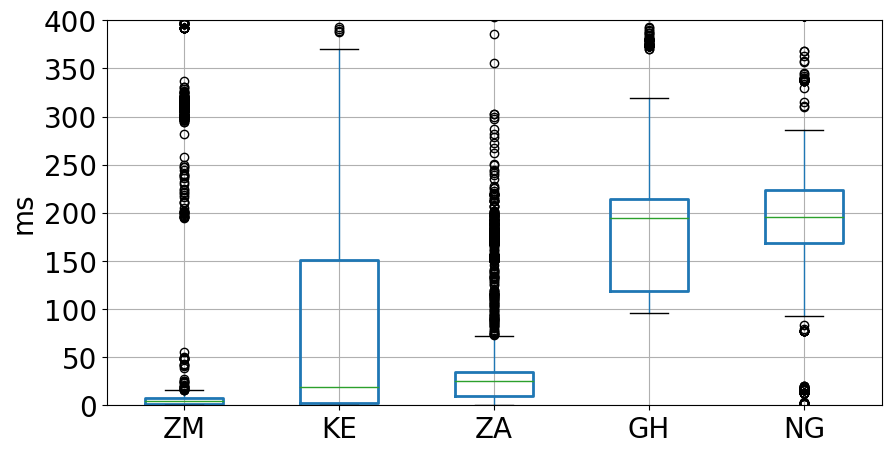

In [54]:
df1 = df.iloc[:,[2,15]]

axes = boxplot_sorted(df1, by=["vantageCC"], column="rtt")
axes.figure.set_size_inches(10,5)
#axes.set_title("Boxplot of RTT by origin country")
axes.set_ylim([0,400])
axes.set_ylabel("ms", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("data/plots/boxplot_rtt.pdf", bbox_inches='tight')
plt.show()

## Boxplot of RTT by destination country (where content is hosted)

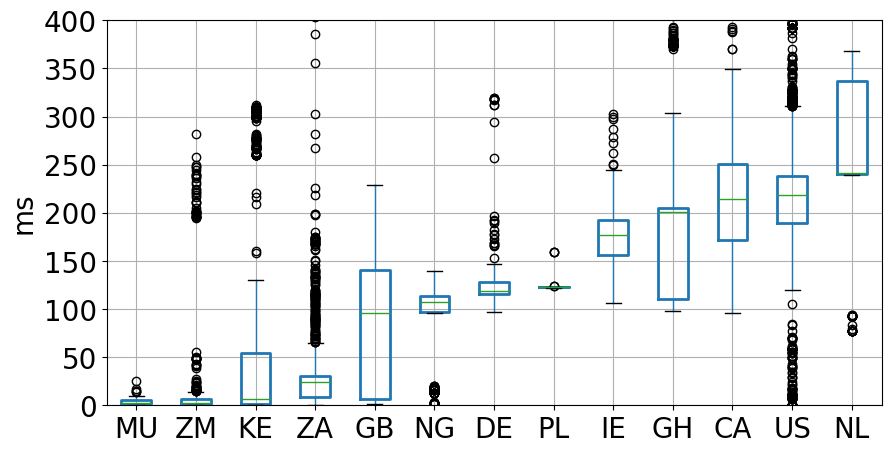

In [55]:
df2 = df.iloc[:,[6,15]]

axes = boxplot_sorted(df2, by=["destCC"], column="rtt")
axes.figure.set_size_inches(10,5)
#axes.set_title("Boxplot of RTT by destination country")
axes.set_ylim([0,400])
axes.set_ylabel("ms", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("data/plots/boxplot_rtt_dest.pdf", bbox_inches='tight')
plt.show()

## CDF of RTT in between countries

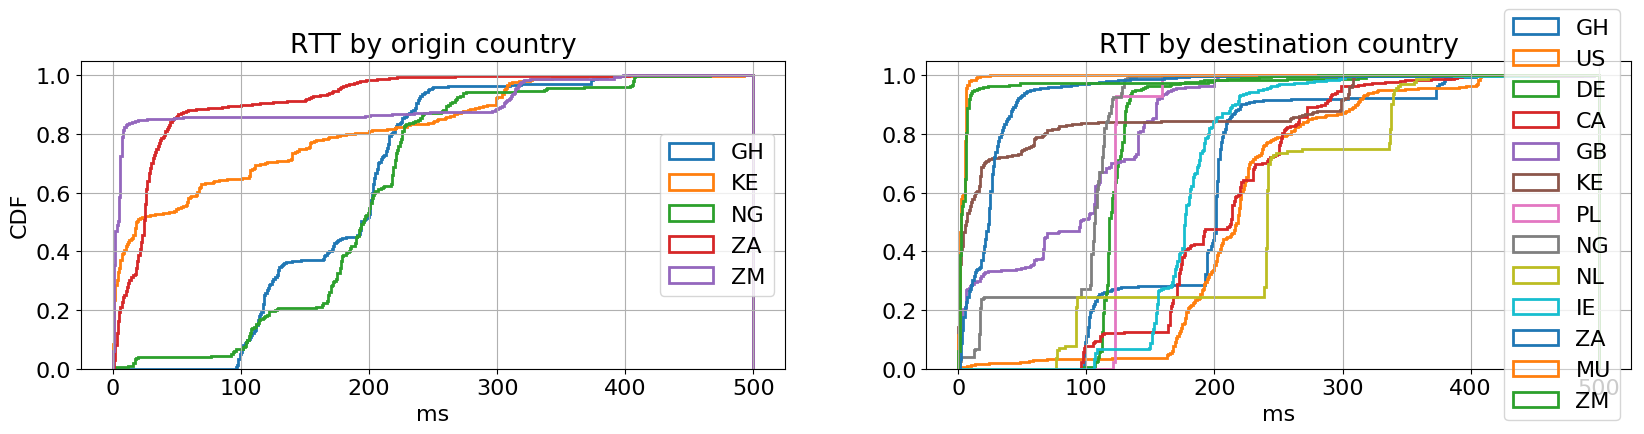

In [72]:
df_cc_origin = df1['vantageCC'].drop_duplicates()
df_cc_dest = df2['destCC'].drop_duplicates()

n_bins = 500
plt.rcParams.update({'font.size': 16})


fig, (ax1, ax2) = plt.subplots(figsize=(20, 4), ncols=2)

for index, cc in df_cc_origin.iteritems():
    # plot the cumulative histogram
    array = df1.loc[df1['vantageCC']==cc].iloc[:,[1]].values
    
    ax1.hist(array, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)

# tidy up the figure
ax1.grid(True)
ax1.legend(loc='right')
ax1.set_title('RTT by origin country')
ax1.set_xlabel('ms')
ax1.set_ylabel('CDF')


for index, cc in df_cc_dest.iteritems():
    # plot the cumulative histogram
    array = df2.loc[df2['destCC']==cc].iloc[:,[1]].values
    
    ax2.hist(array, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)
    
# tidy up the figure
ax2.grid(True)
ax2.legend(loc='right')
ax2.set_title('RTT by destination country')
ax2.set_xlabel('ms')
#ax2.set_ylabel('CDF')
plt.savefig("data/plots/cdf_rtt_cc.pdf", bbox_inches='tight')
plt.show()


## RTT by hosting providers

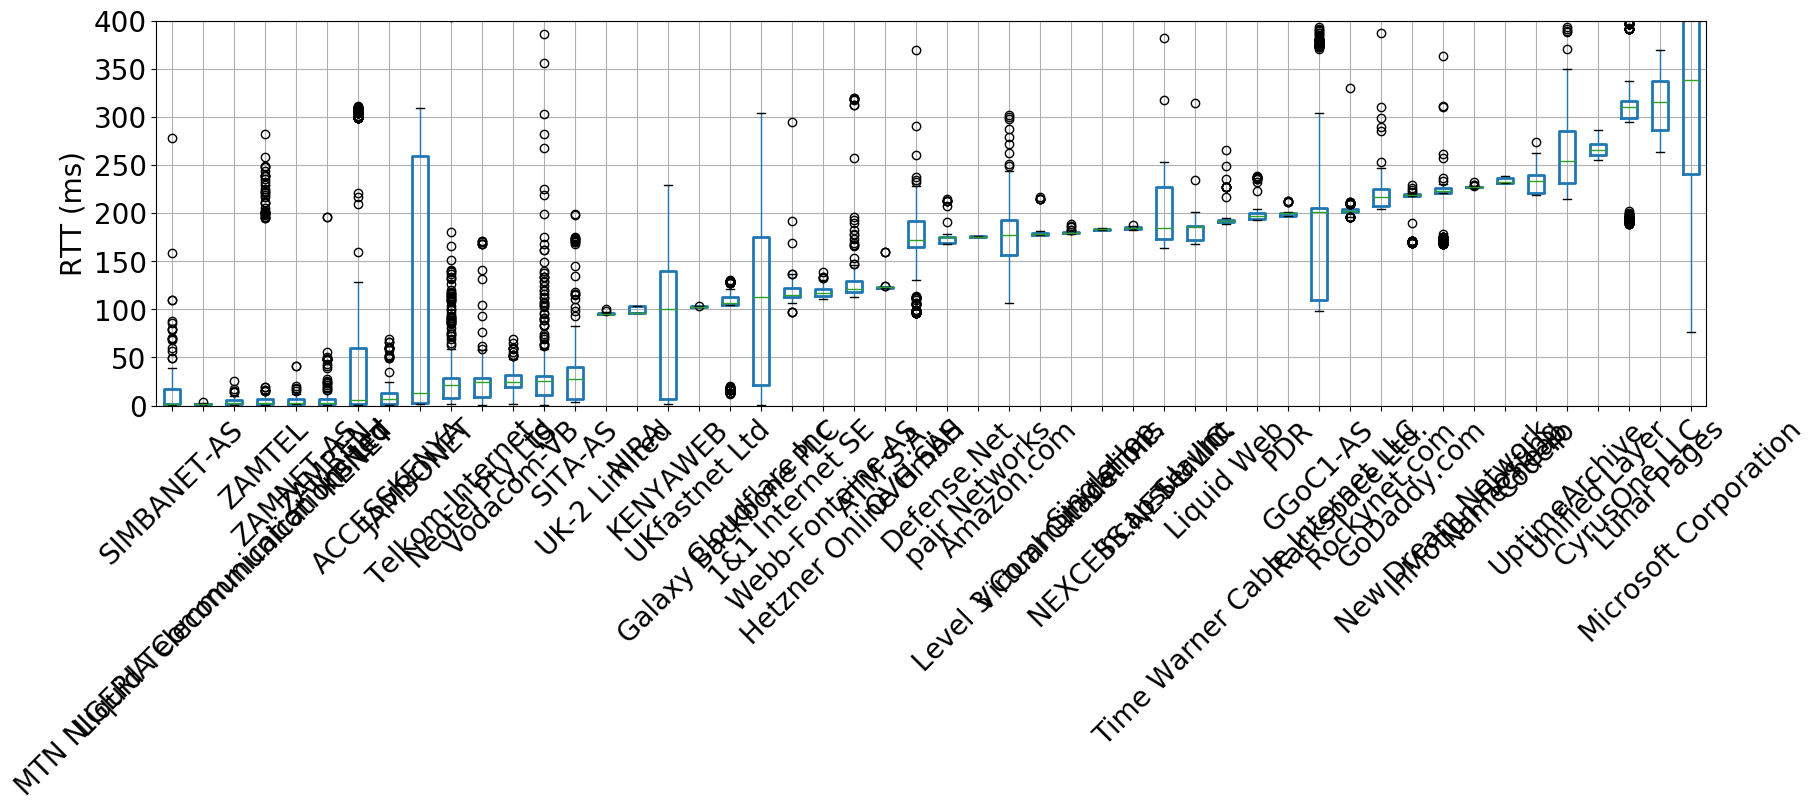

In [82]:
df3 = df.iloc[:,[9,15]]

axes = boxplot_sorted(df3, by=["hostCo"], column="rtt")
axes.figure.set_size_inches(20,5)
#axes.set_title("Boxplot of RTT by hosting provider")
axes.set_ylim([0,400])
axes.set_ylabel("RTT (ms)", fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)

plt.savefig("data/plots/hostCo_rtt.pdf", bbox_inches='tight')
plt.show()

### Distribution of websites Locally hosted, Remotely hosted

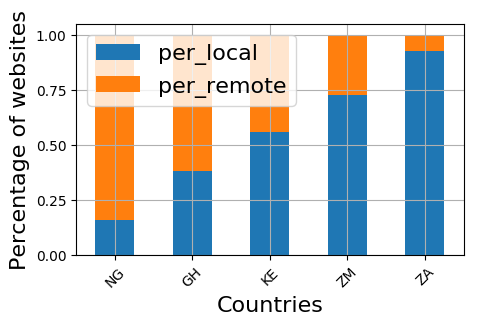

In [83]:
df4 = df.iloc[:,[2,10]]

df4 = df4.groupby(['vantageCC', 'remote']).size().reset_index(name='counts')
df4 = df4.pivot('vantageCC', 'remote').fillna(0)

#df4_local = pd.DataFrame(columns=['vantageCC', 'local'])
#df4_remote = pd.DataFrame(columns=['vantageCC', 'remote'])

df4 = pd.DataFrame(list(df4.itertuples()))
df4.columns = ['vantageCC', 'local','remote']

df4['total'] = df4.sum(axis=1)

df4['per_local'] = df4['local'].div(df4['total'])
df4['per_remote'] = df4['remote'].div(df4['total'])

df4 = df4.iloc[:,[0,4,5]]

df4 = df4.sort_values(by='per_local', ascending=True)


df4.plot.bar(stacked=True, figsize=(5,3), x='vantageCC', rot=45, fontsize=10)
plt.ylabel('Percentage of websites')
plt.grid(True)
#plt.title("Distribution of local and remote websites by country")
plt.xlabel('Countries')
plt.savefig("data/plots/local_remote.pdf", bbox_inches='tight')
plt.show()

## Matrix of mean/median latency between countries

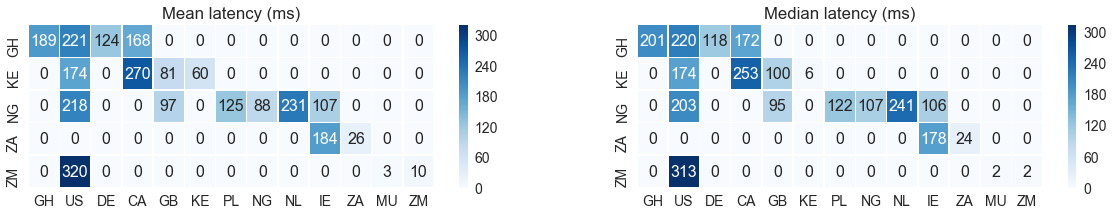

In [40]:
df5 = df.iloc[:, [2, 6, 15]]
df5_mean = df5.groupby(['vantageCC', 'destCC'], as_index=False).mean()
df5_median = df5.groupby(['vantageCC', 'destCC'], as_index=False).median()

Index = df5.iloc[:,[0]].drop_duplicates()['vantageCC'].values
Cols = df5.iloc[:,[1]].drop_duplicates()['destCC'].values

w = len(Index)
h = len(Cols)

Matrix_mean = np.zeros(shape=(w,h), dtype=int)
Matrix_median = np.zeros(shape=(w,h), dtype=int)

for i in range(w):
      for j in range(h):
        v_mean = df5_mean[(df5_mean.vantageCC==Index[i]) & (df5_mean.destCC==Cols[j])]['rtt']
        v_median = df5_median[(df5_median.vantageCC==Index[i]) & (df5_median.destCC==Cols[j])]['rtt']
        if (len(v_mean.values > 0)):
            Matrix_mean[i,j] = int(v_mean.values[0])
        if (len(v_median.values > 0)):
            Matrix_median[i,j] = int(v_median.values[0])

df_matrix_mean = pd.DataFrame(Matrix_mean, index=Index, columns=Cols)
df_matrix_median = pd.DataFrame(Matrix_median, index=Index, columns=Cols)

#print(df_matrix_median)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,3))
ax1.set_title("Mean latency (ms)")
ax2.set_title("Median latency (ms)")

sns.set(font_scale=1.4)
sns.heatmap(ax=ax1, cmap='Blues', linewidths=0.5, data=df_matrix_mean, annot=True, fmt='g', annot_kws={"size": 16})
sns.heatmap(ax=ax2, cmap='Blues', linewidths=0.5, data=df_matrix_median, annot=True, fmt='g', annot_kws={"size": 16})

plt.savefig("data/plots/heatmaps.pdf", bbox_inches='tight')

### Locally hosted website with tromboning vs local no tromboning vs remotely hosted

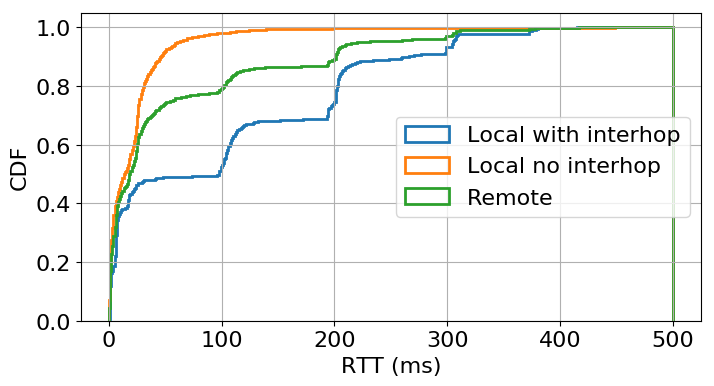

In [73]:
df_local_wt = df.loc[(df.remote==0) & (df.interCC==1)]
df_local_wt = df_local_wt.iloc[:,[2, 6, 15 ]]

df_local_nt = df.loc[(df.remote==0) & (df.interCC==0)]
df_local_nt = df_local_nt.iloc[:,[2, 6, 15 ]]

df_remote = df.loc[df.remote==0]

n_bins = 500

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df_local_wt['rtt'].values, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label="Local with interhop")
ax.hist(df_local_nt['rtt'].values, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label="Local no interhop")
ax.hist(df_remote['rtt'].values, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label="Remote")

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('RTT for Locally hosted vs Locally hosted with interhop vs Remotely hosted')
ax.set_xlabel('RTT (ms)')
ax.set_ylabel('CDF')


plt.savefig("data/plots/cdf_rtt_hosting_type.pdf", bbox_inches='tight')
plt.show()




### Distribution of hosting provider by country

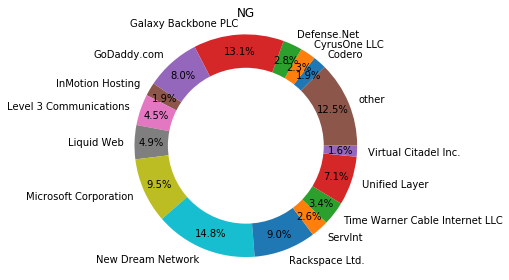

In [10]:
cc='NG'
df_cc = df.loc[(df.vantageCC==cc)]
df_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCo').size().reset_index(name='counts')

percentile = df_cc.quantile(.50)['counts']

df_cc_upper = df_cc.loc[df_cc.counts >= percentile]
df_cc_lower = df_cc.loc[df_cc.counts < percentile]

df_other = pd.DataFrame(columns=['hostCo','counts'])
df_other.loc[0] = ['other', df_cc_lower['counts'].sum()]

df_pie = [df_cc_upper,df_other]

result = pd.concat(df_pie)

# Pie chart
labels = result['hostCo'].values
sizes = result['counts'].values

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title(cc)

plt.tight_layout()
#plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.svg")
plt.show()

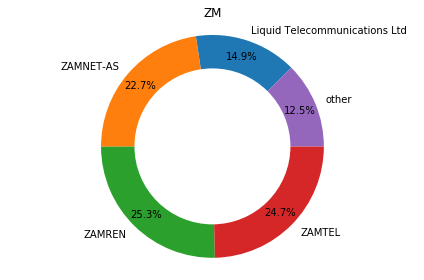

In [11]:
cc='ZM'
df_cc = df.loc[(df.vantageCC==cc)]
df_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCo').size().reset_index(name='counts')

labels, sizes = getPieDataByPercentile(df_cc, .25)

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title(cc)

plt.tight_layout()
#plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.svg")
plt.show()

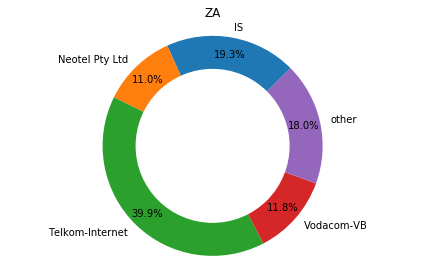

In [12]:
cc='ZA'
df_cc = df.loc[(df.vantageCC==cc)]
df_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCo').size().reset_index(name='counts')

labels, sizes = getPieDataByPercentile(df_cc, .25)

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title(cc)

plt.tight_layout()
#plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.svg")
plt.show()

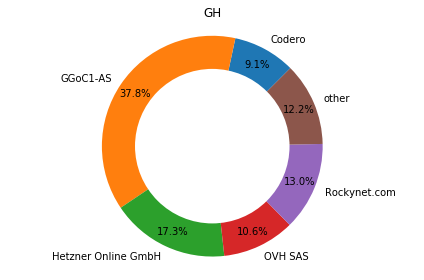

In [13]:
cc='GH'
df_cc = df.loc[(df.vantageCC==cc)]
df_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCo').size().reset_index(name='counts')

labels, sizes = getPieDataByPercentile(df_cc, .25)

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title(cc)

plt.tight_layout()
#plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.svg")
plt.show()

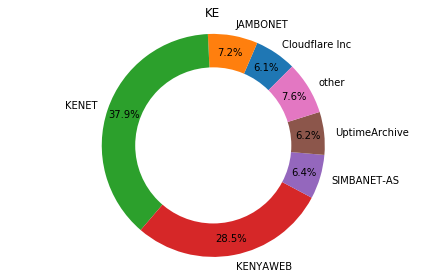

In [14]:
cc='KE'
df_cc = df.loc[(df.vantageCC==cc)]
df_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCo').size().reset_index(name='counts')

labels, sizes = getPieDataByPercentile(df_cc, .25)

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title(cc)

plt.tight_layout()
#plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.svg")
plt.show()

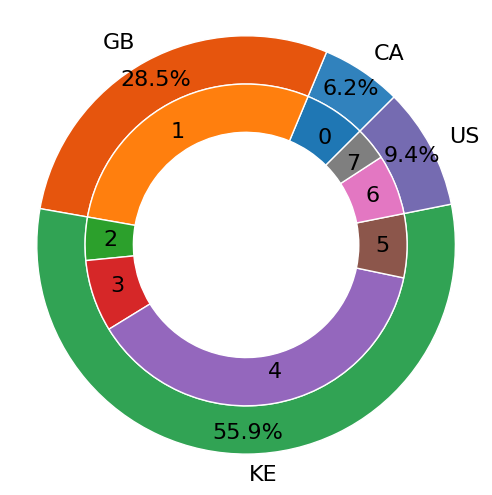

['0 - CA/UptimeArchive (6.2 %)',
 '1 - GB/KENYAWEB (28.5 %)',
 '2 - KE/ACCESSKENYA (4.3 %)',
 '3 - KE/JAMBONET (7.2 %)',
 '4 - KE/KENET (37.9 %)',
 '5 - KE/SIMBANET-AS (6.4 %)',
 '6 - US/Cloudflare Inc (6.1 %)',
 '7 - US/Lunar Pages (3.3 %)']

In [75]:
cc='KE'

df_cc = df.loc[(df.vantageCC==cc)]
df_by_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCC').size().reset_index(name='counts')
df_by_cc_host = (df_cc.iloc[:,[7,9]]).groupby(['hostCC','hostCo']).size().reset_index(name='counts')
df_by_cc_host['label'] = df_by_cc_host.index

#add a percentage column
df_by_cc['percentage'] = df_by_cc.counts/sum(df_by_cc['counts'].values)*100
df_by_cc_host['percentage'] = df_by_cc_host.counts/sum(df_by_cc_host['counts'].values)*100


group_names = df_by_cc['hostCC'].values
group_size = df_by_cc['percentage'].values

subgroup_cc = df_by_cc_host['hostCC'].values
subgroup_labels = df_by_cc_host['label'].values
subgroup_names = df_by_cc_host['hostCo'].values
subgroup_size = df_by_cc_host['percentage'].values

fig, ax2 = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(group_names))*4)

plt.pie(group_size, radius=1.3, 
        labels=group_names, autopct='%1.1f%%', startangle=45, pctdistance=0.9, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(subgroup_size, radius=1.3-0.3, 
        labels=subgroup_labels, labeldistance=0.8, startangle=45, pctdistance=0.85,
           wedgeprops=dict(width=0.3, edgecolor='w'))


#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Source country:" + cc)


#plt.legend(handlelength=0, bbox_to_anchor=(0.75,1.55), 
           #labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)])

#plt.tight_layout()
plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.pdf", bbox_inches='tight')
plt.show()

labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) 
        for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)]
labels

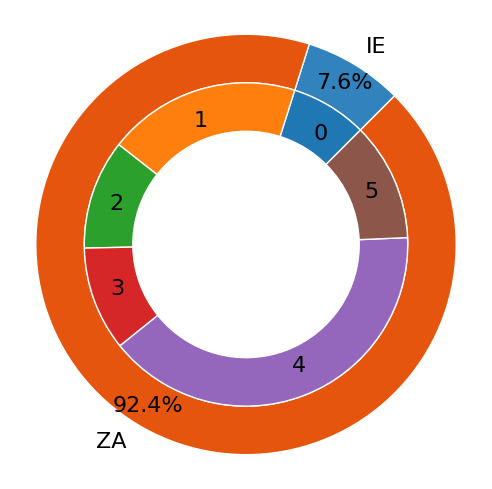

['0 - IE/Amazon.com (7.6 %)',
 '1 - ZA/IS (19.3 %)',
 '2 - ZA/Neotel Pty Ltd (11.0 %)',
 '3 - ZA/SITA-AS (10.4 %)',
 '4 - ZA/Telkom-Internet (39.9 %)',
 '5 - ZA/Vodacom-VB (11.8 %)']

In [81]:
cc='ZA'

df_cc = df.loc[(df.vantageCC==cc)]
df_by_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCC').size().reset_index(name='counts')
df_by_cc_host = (df_cc.iloc[:,[7,9]]).groupby(['hostCC','hostCo']).size().reset_index(name='counts')
df_by_cc_host['label'] = df_by_cc_host.index

#add a percentage column
df_by_cc['percentage'] = df_by_cc.counts/sum(df_by_cc['counts'].values)*100
df_by_cc_host['percentage'] = df_by_cc_host.counts/sum(df_by_cc_host['counts'].values)*100


group_names = df_by_cc['hostCC'].values
group_size = df_by_cc['percentage'].values

subgroup_cc = df_by_cc_host['hostCC'].values
subgroup_labels = df_by_cc_host['label'].values
subgroup_names = df_by_cc_host['hostCo'].values
subgroup_size = df_by_cc_host['percentage'].values

fig, ax2 = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(group_names))*4)

plt.pie(group_size, radius=1.3, 
        labels=group_names, autopct='%1.1f%%', startangle=45, pctdistance=0.9, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(subgroup_size, radius=1.3-0.3, 
        labels=subgroup_labels, labeldistance=0.8, startangle=45, pctdistance=0.85,
           wedgeprops=dict(width=0.3, edgecolor='w'))


#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Source country:" + cc)

#plt.legend(handlelength=0, bbox_to_anchor=(0.85,1.45), 
           #labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)])

#plt.tight_layout()
plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.pdf", bbox_inches='tight')
plt.show()

labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) 
        for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)]
labels

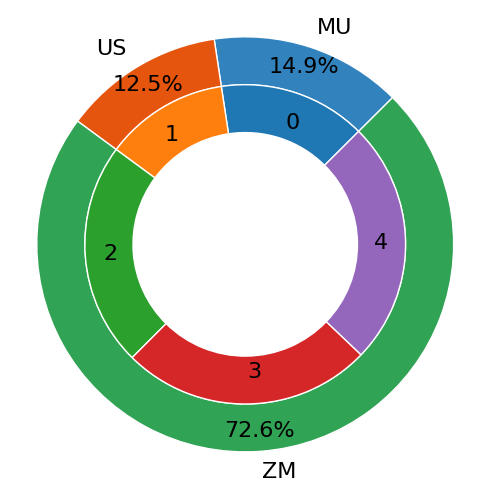

['0 - MU/Liquid Telecommunications Ltd (14.9 %)',
 '1 - US/CyrusOne LLC (12.5 %)',
 '2 - ZM/ZAMNET-AS (22.7 %)',
 '3 - ZM/ZAMREN (25.3 %)',
 '4 - ZM/ZAMTEL (24.7 %)']

In [80]:
cc='ZM'

df_cc = df.loc[(df.vantageCC==cc)]
df_by_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCC').size().reset_index(name='counts')
df_by_cc_host = (df_cc.iloc[:,[7,9]]).groupby(['hostCC','hostCo']).size().reset_index(name='counts')
df_by_cc_host['label'] = df_by_cc_host.index

#add a percentage column
df_by_cc['percentage'] = df_by_cc.counts/sum(df_by_cc['counts'].values)*100
df_by_cc_host['percentage'] = df_by_cc_host.counts/sum(df_by_cc_host['counts'].values)*100


group_names = df_by_cc['hostCC'].values
group_size = df_by_cc['percentage'].values

subgroup_cc = df_by_cc_host['hostCC'].values
subgroup_labels = df_by_cc_host['label'].values
subgroup_names = df_by_cc_host['hostCo'].values
subgroup_size = df_by_cc_host['percentage'].values

fig, ax2 = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(group_names))*4)

plt.pie(group_size, radius=1.3, 
        labels=group_names, autopct='%1.1f%%', startangle=45, pctdistance=0.9, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(subgroup_size, radius=1.3-0.3, 
        labels=subgroup_labels, labeldistance=0.8, startangle=45, pctdistance=0.85,
           wedgeprops=dict(width=0.3, edgecolor='w'))


#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Source country:" + cc)

#plt.legend(handlelength=0, bbox_to_anchor=(0.85,1.45), 
           #labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)])

#plt.tight_layout()
plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.pdf", bbox_inches='tight')
plt.show()

labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) 
        for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)]
labels

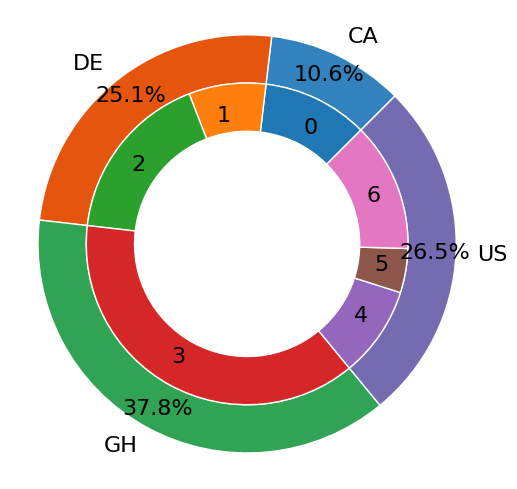

['0 - CA/OVH SAS (10.6 %)',
 '1 - DE/1&1 Internet SE (7.7 %)',
 '2 - DE/Hetzner Online GmbH (17.3 %)',
 '3 - GH/GGoC1-AS (37.8 %)',
 '4 - US/Codero (9.1 %)',
 '5 - US/Incapsula Inc (4.4 %)',
 '6 - US/Rockynet.com (13.0 %)']

In [77]:
cc='GH'

df_cc = df.loc[(df.vantageCC==cc)]
df_by_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCC').size().reset_index(name='counts')
df_by_cc_host = (df_cc.iloc[:,[7,9]]).groupby(['hostCC','hostCo']).size().reset_index(name='counts')
df_by_cc_host['label'] = df_by_cc_host.index

#add a percentage column
df_by_cc['percentage'] = df_by_cc.counts/sum(df_by_cc['counts'].values)*100
df_by_cc_host['percentage'] = df_by_cc_host.counts/sum(df_by_cc_host['counts'].values)*100


group_names = df_by_cc['hostCC'].values
group_size = df_by_cc['percentage'].values

subgroup_cc = df_by_cc_host['hostCC'].values
subgroup_labels = df_by_cc_host['label'].values
subgroup_names = df_by_cc_host['hostCo'].values
subgroup_size = df_by_cc_host['percentage'].values

fig, ax2 = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(group_names))*4)

plt.pie(group_size, radius=1.3, 
        labels=group_names, autopct='%1.1f%%', startangle=45, pctdistance=0.9, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(subgroup_size, radius=1.3-0.3, 
        labels=subgroup_labels, labeldistance=0.8, startangle=45, pctdistance=0.85,
           wedgeprops=dict(width=0.3, edgecolor='w'))


#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Source country:" + cc)

#plt.legend(handlelength=0,  bbox_to_anchor=(0.85,1.45),
           #labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)])

#plt.tight_layout()
plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.pdf", bbox_inches='tight')
plt.show()

labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) 
        for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)]
labels

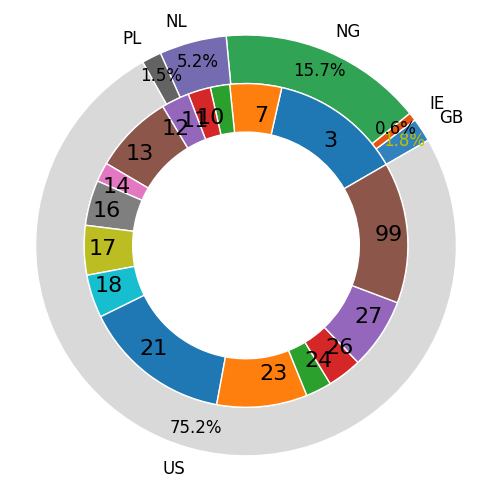

['3 - NG/Galaxy Backbone PLC (13.1 %)',
 '7 - NL/Microsoft Corporation (5.2 %)',
 '10 - US/Codero (1.9 %)',
 '11 - US/CyrusOne LLC (2.3 %)',
 '12 - US/Defense.Net (2.8 %)',
 '13 - US/GoDaddy.com (8.0 %)',
 '14 - US/InMotion Hosting (1.9 %)',
 '16 - US/Level 3 Communications (4.5 %)',
 '17 - US/Liquid Web (4.9 %)',
 '18 - US/Microsoft Corporation (4.3 %)',
 '21 - US/New Dream Network (14.8 %)',
 '23 - US/Rackspace Ltd. (9.0 %)',
 '24 - US/ServInt (2.6 %)',
 '26 - US/Time Warner Cable Internet LLC (3.4 %)',
 '27 - US/Unified Layer (7.1 %)',
 '99 - ZZ/other (14.1 %)']

In [79]:
cc='NG'

df_cc = df.loc[(df.vantageCC==cc)]
df_by_cc = (df_cc.iloc[:,[7,9]]).groupby('hostCC').size().reset_index(name='counts')
df_by_cc_host = (df_cc.iloc[:,[7,9]]).groupby(['hostCC','hostCo']).size().reset_index(name='counts')
df_by_cc_host['label'] = df_by_cc_host.index

#add a percentage column
df_by_cc['percentage'] = df_by_cc.counts/sum(df_by_cc['counts'].values)*100
df_by_cc_host['percentage'] = df_by_cc_host.counts/sum(df_by_cc_host['counts'].values)*100

percentile = df_by_cc_host.quantile(0.50)['counts']

df_upper = df_by_cc_host.loc[df_by_cc_host.counts >= percentile]
df_lower = df_by_cc_host.loc[df_by_cc_host.counts < percentile]

df_other = pd.DataFrame(columns=['counts','hostCC','label','percentage', 'hostCo'])
df_other.loc[0] = [df_lower['counts'].sum(), 'ZZ', '99',df_lower['percentage'].sum() , 'other']

df_pie = [df_upper,df_other]

df_by_cc_host = pd.concat(df_pie, sort=True)

group_names = df_by_cc['hostCC'].values
group_size = df_by_cc['percentage'].values

subgroup_cc = df_by_cc_host['hostCC'].values
subgroup_labels = df_by_cc_host['label'].values
subgroup_names = df_by_cc_host['hostCo'].values
subgroup_size = df_by_cc_host['percentage'].values

fig, ax2 = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(group_names))*4)

patches, texts, autotexts = plt.pie(group_size, radius=1.3, 
        labels=group_names, autopct='%1.1f%%', startangle=30, pctdistance=0.9, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(subgroup_size, radius=1.3-0.3, 
        labels=subgroup_labels, labeldistance=0.8, startangle=30, pctdistance=0.85,
           wedgeprops=dict(width=0.3, edgecolor='w'))

for t in texts:
    t.set_size(12)
for t in autotexts:
    t.set_size(12)
autotexts[0].set_color('y')

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Source country:" + cc)

#plt.legend(handlelength=0, bbox_to_anchor=(1.05,1.05), 
           #labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)])

#plt.tight_layout()
plt.savefig("data/plots/pie_chart_" + cc + "_hosting_providers.pdf", bbox_inches='tight')
plt.show()

labels=['%s - %s/%s (%1.1f %%)' % (m, cc, l, s) 
        for m, cc, l, s in zip(subgroup_labels, subgroup_cc, subgroup_names, subgroup_size)]
labels

In [20]:
patches